# PS3-4: Semi-supervised EM

## Import Library

In [366]:
import numpy as np
import matplotlib.pyplot as plt
import os

import Full_Problem_Set.PS3.src.p04_gmm as gmm

## Global Parameter

In [367]:
PLOT_COLORS = ['red', 'green', 'blue', 'orange']  # Colors for your plots
K = 4           # Number of Gaussians in the mixture model
NUM_TRIALS = 3  # Number of trials to run (can be adjusted for debugging)
UNLABELED = -1  # Cluster label for unlabeled data points (do not change)

## Load Dataset

In [368]:
#Train
x_train, z_train = gmm.load_gmm_dataset("/home/anhnt02/Desktop/CS229-Fall2018-FullCourse/Full_Problem_Set/PS3/data/ds4_train.csv")

#Valid
x_valid, z_valid = gmm.load_gmm_dataset("/home/anhnt02/Desktop/CS229-Fall2018-FullCourse/Full_Problem_Set/PS3/data/ds4_valid.csv")

#Test
x_test, z_test = gmm.load_gmm_dataset("/home/anhnt02/Desktop/CS229-Fall2018-FullCourse/Full_Problem_Set/PS3/data/ds4_test.csv")

## Plot Training set

In [369]:
def plot_dataset(x, z):
    plt.figure(figsize=(10, 8))
    plt.title('Training Dataset')
    plt.xlabel('x_1')
    plt.ylabel('x_2')

    for x_1, x_2, z_ in zip(x[:, 0], x[:, 1], z):
        color = 'gray' if z_ < 0 else PLOT_COLORS[int(z_)]
        alpha = 0.25 if z_ < 0 else 0.75
        plt.scatter(x_1, x_2, marker='.', c=color, alpha=alpha)


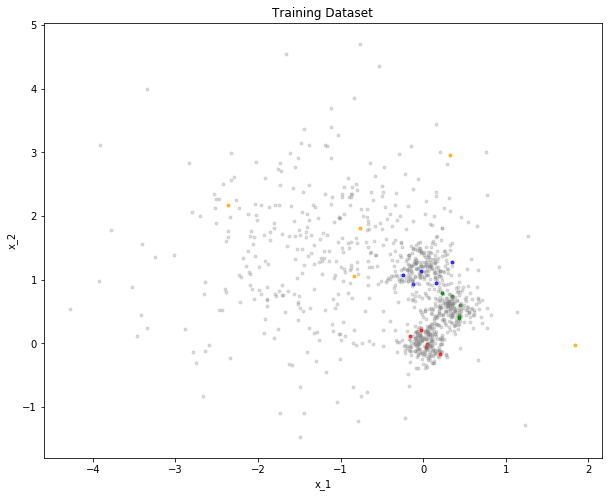

In [370]:
#Plot Training set
plot_dataset(x_train, z_train)

## Training semi-EM Model

### Training Algorithm

In [371]:
z_train = z_train.ravel()  # convert to vector 1D

#Get Feature X_labeled Size
m, n = x_train[z_train == UNLABELED].shape

#Get Feature X_tilde Size
m_tilde, n_tilde = x_train[z_train != UNLABELED].shape

In [372]:
def gaussian_pdf(x, mu, sigma):
    det_cov = np.linalg.det(sigma)
    inv_cov = np.linalg.inv(sigma)
    A = 1 / (pow(2 * np.pi, n/2) * np.sqrt(det_cov))
    B = np.exp(-0.5 * (x - mu).T @ inv_cov @ (x - mu))
    pdf = A * B
    return pdf

In [373]:
def run_em(x, w, phi, mu, sigma):
    """
    Args:
        x: Design matrix of shape (m, n).
        w: Initial weight matrix of shape (m, k).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, list of k arrays of shape (n,).
        sigma: Initial cluster covariances, list of k arrays of shape (n, n).

    Returns:
        Updated weight matrix of shape (m, k) resulting from EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """
    # No need to change any of these parameters
    eps = 1e-3  # Convergence threshold
    max_iter = 1000

    # Stop when the absolute change in log-likelihood is < eps
    # See below for explanation of the convergence criterion
    it = 0
    ll = prev_ll = None
    while it < max_iter and (prev_ll is None or np.abs(ll - prev_ll) >= eps):
        prev_ll = ll
        # *** START CODE HERE
        # (1) E-step: Update your estimates in w
        for i in range(m):
            numerator = np.zeros(K)
            for j in range(K):
                numerator[j] = gaussian_pdf(x[i], mu[j], sigma[j]) * phi[j]

            denominator = 0
            for l in range(K):
                denominator += gaussian_pdf(x[i], mu[l], sigma[l]) * phi[l]

            w[i, :] = numerator / denominator

        # (2) M-step: Update the model parameters phi, mu, and sigma
        #===============Update Phi[j]===============
        for j in range(K):
            phi[j] = 0
            for i in range(m):
                phi[j] += 1/m * w[i, j]

        #===============Update Mu[j]===============
        for j in range(K):
            numerator = np.zeros(n)
            denominator = 0
            for i in range(m):
                numerator += w[i, j] * x[i]
                denominator += w[i, j]
            mu[j] = numerator / denominator

        #===============Update Cov[j]===============
        for j in range(K):
            numerator = np.zeros((n, n))
            denominator = 0
            for i in range(m):
                diff = (x[i] - mu[j]).reshape(-1, 1)
                numerator += w[i, j] * (diff @ diff.T)
                denominator += w[i, j]
            sigma[j] = numerator / denominator

        # (3) Compute the log-likelihood of the data to check for convergence.
        # By log-likelihood, we mean `ll = sum_x[log(sum_z[p(x|z) * p(z)])]`.
        # We define convergence by the first iteration where abs(ll - prev_ll) < eps.
        # Hint: For debugging, recall part (a). We showed that ll should be monotonically increasing.
        ll = 0.0
        for i in range(m):
            temp = 0
            for j in range(K):
                temp += gaussian_pdf(x[i], mu[j], sigma[j]) * phi[j]
            ll += np.log(temp)

        it += 1
        # *** END CODE HERE ***

    return w, ll, it

In [374]:
def run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma):
    """
    Args:
        x: Design matrix of unlabeled examples of shape (m, n).
        x_tilde: Design matrix of labeled examples of shape (m_tilde, n).
        z: Array of labels of shape (m_tilde, 1).
        w: Initial weight matrix of shape (m, k).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, list of k arrays of shape (n,).
        sigma: Initial cluster covariances, list of k arrays of shape (n, n).

    Returns:
        Updated weight matrix of shape (m, k) resulting from semi-supervised EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """
    # No need to change any of these parameters
    alpha = 20.  # Weight for the labeled examples
    eps = 1e-3   # Convergence threshold
    max_iter = 1000

    # Stop when the absolute change in log-likelihood is < eps
    # See below for explanation of the convergence criterion
    it = 0
    ll = prev_ll = None
    while it < max_iter and (prev_ll is None or np.abs(ll - prev_ll) >= eps):
        prev_ll = ll
        # *** START CODE HERE ***
        # (1) E-step: Update your estimates in w
        #Unlabeled Part
        for i in range(m):
            numerator = np.zeros(K)
            for j in range(K):
                numerator[j] = gaussian_pdf(x[i], mu[j], sigma[j]) * phi[j]

            denominator = 0
            for l in range(K):
                denominator += gaussian_pdf(x[i], mu[l], sigma[l]) * phi[l]

            w[i, :] = numerator / denominator

        #Labeled Part
        for i in range(m_tilde):
            for j in range(K):
                if int(z[i]) == j:
                    w[i, j] = 1
                else:
                    w[i, j] = 0

        # (2) M-step: Update the model parameters phi, mu, and sigma
        #========================Update Phi[j]========================
        for j in range(K):
            #Labeled Part
            labeled_sum = 0
            for i in range(m_tilde):
                if int(z[i]) == j:
                    labeled_sum += 1

            #Unlabeled Part
            unlabeled_sum = 0
            for i in range(m):
                unlabeled_sum += w[i, j]

            phi[j] = 1/(m + alpha * m_tilde) * (unlabeled_sum + alpha * labeled_sum)

        #========================Update Mu[j]========================
        for j in range(K):
            ###Numerator
            #Labeled Part
            nume_labeled_sum = 0
            for i in range(m_tilde):
                if int(z[i]) == j:
                    nume_labeled_sum += 1 * x_tilde[i]

            #Unlabeled Part
            nume_unlabeled_sum = 0
            for i in range(m):
                nume_unlabeled_sum += w[i, j] * x[i]

            numerator = nume_unlabeled_sum + alpha * nume_labeled_sum

            ###Denominator
            #Labeled Part
            deno_labeled_sum = 0
            for i in range(m_tilde):
                if int(z[i]) == j:
                    deno_labeled_sum += 1

            #Unlabeled Part
            deno_unlabeled_sum = 0
            for i in range(m):
                deno_unlabeled_sum += w[i, j]

            denominator = deno_unlabeled_sum + alpha * deno_labeled_sum

            ###Calculate Mu[j]
            mu[j] = numerator / denominator

        #========================Update Cov[j]========================
        for j in range(K):
            ###Numerator
            #Labeled Part
            nume_labeled_sum = 0
            for i in range(m_tilde):
                if int(z[i]) == j:
                    diff_labeled = (x_tilde[i] - mu[j]).reshape(-1, 1)
                    nume_labeled_sum += 1 * (diff_labeled @ diff_labeled.T)

            #Unlabeled Part
            nume_unlabeled_sum = 0
            for i in range(m):
                diff_unlabeled = (x[i] - mu[j]).reshape(-1, 1)
                nume_unlabeled_sum += w[i, j] * (diff_unlabeled @ diff_unlabeled.T)

            numerator = nume_unlabeled_sum + alpha * nume_labeled_sum

            ###Denominator
            #Labeled Part
            deno_labeled_sum = 0
            for i in range(m_tilde):
                if int(z[i]) == j:
                    deno_labeled_sum += 1

            #Unlabeled Part
            deno_unlabeled_sum = 0
            for i in range(m):
                deno_unlabeled_sum += w[i, j]

            denominator = deno_unlabeled_sum + alpha * deno_labeled_sum

            ###Calculate Cov[j]
            sigma[j] = numerator / denominator

        # (3) Compute the log-likelihood of the data to check for convergence.
        # Hint: Make sure to include alpha in your calculation of ll.
        # Hint: For debugging, recall part (a). We showed that ll should be monotonically increasing.
        #Labeled Part
        ll_labeled = 0
        for i in range(m_tilde):
            ll_labeled += np.log(gaussian_pdf(x_tilde[i], mu[int(z[i])], sigma[int(z[i])]) * phi[int(z[i])])

        #Unlabled Part
        ll_unlabeled = 0
        for i in range(m):
            temp = 0
            for j in range(K):
                temp += gaussian_pdf(x[i], mu[j], sigma[j]) * phi[j]

            ll_unlabeled += np.log(temp)

        #Semi Log-likelihood
        ll = ll_unlabeled + alpha * ll_labeled

        it += 1
        # *** END CODE HERE ***

    return w, ll, it

In [375]:
def main(is_semi_supervised, trial_num):
    """Problem 3: EM for Gaussian Mixture Models (unsupervised and semi-supervised)"""
    print('Running {} EM algorithm...'
          .format('semi-supervised' if is_semi_supervised else 'unsupervised'))

    # Load dataset
    train_path = os.path.join('/home/anhnt02/Desktop/CS229-Fall2018-FullCourse/Full_Problem_Set/PS3/data/ds4_train.csv')
    x, z = gmm.load_gmm_dataset(train_path)
    x_tilde = None

    if is_semi_supervised:
        # Split into labeled and unlabeled examples
        labeled_idxs = (z != UNLABELED).squeeze()
        x_tilde = x[labeled_idxs, :]   # Labeled examples
        z = z[labeled_idxs, :]         # Corresponding labels
        x = x[~labeled_idxs, :]        # Unlabeled examples

    # *** START CODE HERE ***
    # (1) Initialize mu and sigma by splitting the m data points uniformly at random
    # into K groups, then calculating the sample mean and covariance for each group

    #Step 1: Shuffles all index to get random
    shuffled_indices = np.random.permutation(m)

    #Step 2: Split data into K group (contain index of each datapoint for each group)
    K_groups = np.array_split(shuffled_indices, K)

    #Step 3: Calculate mu
    mu = []
    for k_idx in K_groups:
        temp = np.zeros(n)
        for i in k_idx:
            temp += x[i]
        mu.append(temp / len(k_idx))
    mu = np.array(mu)

    #Step 4: Calculate sigma
    sigma = []
    for j in range(K):
        k_idx = K_groups[j]
        temp = np.zeros((n, n))
        for i in k_idx:
            diff = (x[i] - mu[j]).reshape(-1, 1)
            temp += diff @ diff.T
        sigma.append(temp / len(k_idx))
    sigma = np.array(sigma)

    # (2) Initialize phi to place equal probability on each Gaussian
    # phi should be a numpy array of shape (K,)
    phi = np.ones(K) / K

    # (3) Initialize the w values to place equal probability on each Gaussian
    # w should be a numpy array of shape (m, K)
    w = np.ones((m, K)) / K

    # *** END CODE HERE ***

    if is_semi_supervised:
        w, ll, it = run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma)
        print(f"Number Iteration: #{it}")
        print(f"Log-Likelihood: {ll:.3f}")

    else:
        w, ll, it = run_em(x, w, phi, mu, sigma)
        print(f"Number Iteration: #{it}")
        print(f"Log-Likelihood: {ll:.3f}")

    # Plot your predictions
    z_pred = np.zeros(m)
    if w is not None:  # Just a placeholder for the starter code
        for i in range(m):
            z_pred[i] = np.argmax(w[i])

    gmm.plot_gmm_preds(x, z_pred, is_semi_supervised, plot_id=trial_num)

### Training Model

#### d) Classical EM Algorithm

Running unsupervised EM algorithm...
Number Iteration: #198
Log-Likelihood: -1790.829


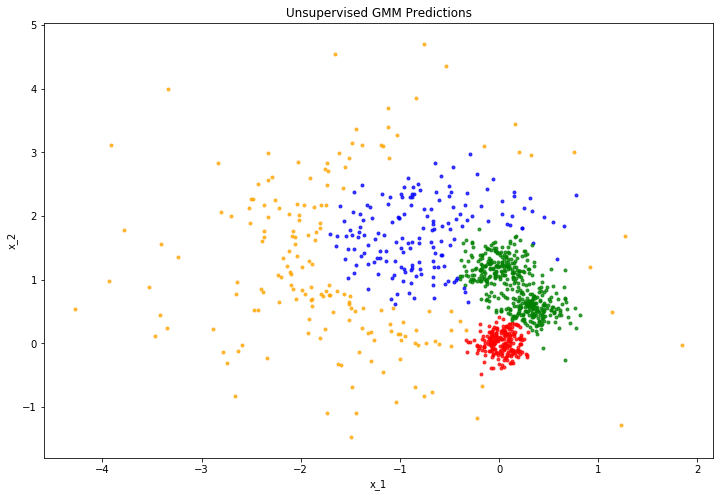

In [376]:
main(is_semi_supervised=False, trial_num=NUM_TRIALS)

#### e) Semi-Unsupervised EM Algorithm

Running semi-supervised EM algorithm...
Number Iteration: #43
Log-Likelihood: -2477.255


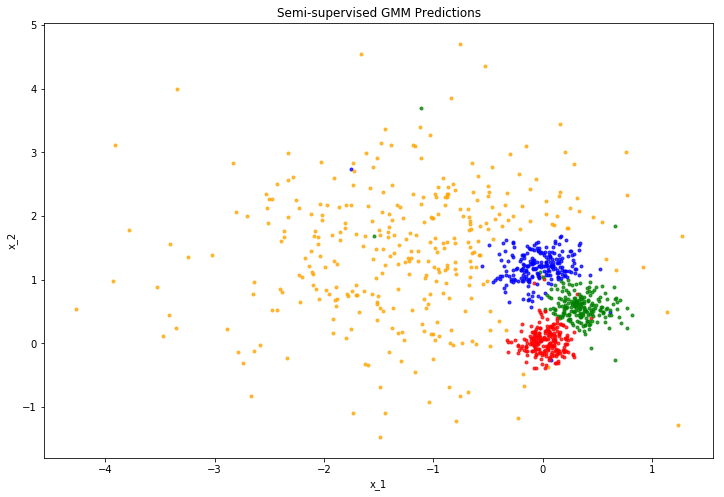

In [377]:
main(is_semi_supervised=True, trial_num=NUM_TRIALS)

#### f) Compare Classical EM Algorithm(CEA) vs. Semi-Supervised EM Algorithm(SSEA)

i. CEA needs more Iteration to Convergence than SSEA

ii. SSEA is more Stable than CEA (Because after we run both of them many times, SSEA just need around 41-43 iterations to converge, while CEA is not like that, It could be any number of iteration depends on the Initialize Value)

iii. In general, SSEA has the better Overall Quality because CEA has 2 low-variance and 2 high-variance Gaussian Distribution. Inversely, SSEA has the exact 3 low-variance and 1 high-variance Gaussian Distribution. (Check the condition in the Note part)